### Prerequisites

In [1]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from copy import deepcopy
import requests
from PIL import Image
import ast

cls_idx = requests.get("https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt")
cls_idx = ast.literal_eval(cls_idx.text)


def load_img(url):
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    transform = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
        ])
    if url.startswith("https"):
        img = Image.open(requests.get(url, stream=True).raw)
    else:
        img = Image.open(url)
    img = transform(img).unsqueeze(0)
    return img


def get_predictions(outp):
    outp = F.softmax(outp, dim=1)
    score, idx = torch.topk(outp, 1)
    idx.squeeze_()
    predicted_label = cls_idx[idx.item()]
    print(predicted_label, '(', score.squeeze().item(), ')')


def print_sizeof(model):
    total = 0
    for p in model.parameters():
        total += p.numel() * p.element_size()
    total /= 1e6
    print("Model size: ", total, " MB")


/opt/miniconda3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


## Fundamentals of Quantization
* Quantization is the process of reducing the size of data. 
* It uses a `mapping function` to convert values in floating-point space to integer space

In [2]:
# floor, ceil and round are also quantization mapping functions

import math

print(math.floor(3.14159265359))
print(math.ceil(3.14159265359))
print(round(3.14159265359))

3
4
3


While its roots are in digital signal processing (for digital encoding and lossy compression), quantization techniques are also used to reduce the size of deep neural networks (DNNs).

DNN parameters are typically 32-bit floating point numbers; using quantization, we can represent them as 8-bit (or lower) integers.

## Quantization of neural networks from scratch

In this workshop, we'll 

a) Load a pretrained Resnet model

b) Quantize the last layer (classifier) from scratch

c) Compare accuracy performance with non-quantized classifier


### Loading the Resnet model

In [3]:
# Load the model
resnet = models.resnet18(pretrained=True).eval()
resnet.requires_grad_(False)

# Extract the classifier before removing from resnet
fp32_fc = deepcopy(resnet.fc)

# Remove classifier from resnet model. This is now a Resnet feature extractor.
resnet.fc = torch.nn.Identity()

Testing that we didn't screw anything up...

In [4]:
wolf_img = "https://raw.githubusercontent.com/pytorch/ios-demo-app/master/HelloWorld/HelloWorld/HelloWorld/image.png"
img = load_img(wolf_img)

model = torch.nn.Sequential(resnet, fp32_fc)
logits = model(img)
get_predictions(logits)

timber wolf, grey wolf, gray wolf, Canis lupus ( 0.44803616404533386 )


### Attempt 1: Round
Quantization mapping functions also include naive functions like `round`. 

In [5]:
rounded_fc = deepcopy(fp32_fc)
rounded_fc.weight = torch.nn.Parameter(torch.round(rounded_fc.weight), requires_grad=False)
rounded_fc.bias = torch.nn.Parameter(torch.round(rounded_fc.bias), requires_grad=False)

Sounds too good to be true?

In [6]:
model = torch.nn.Sequential(resnet, rounded_fc)
logits = model(img)
get_predictions(logits)

rhinoceros beetle ( 0.01966511830687523 )


You already knew [this wouldn't work](https://en.wikipedia.org/wiki/There_ain%27t_no_such_thing_as_a_free_lunch), but it's good to get it out of the way.

The reason this failed is because our classifier's parameters are between [-0.2, 0.4]. By directly rounding these, we just zeroed out our layer!

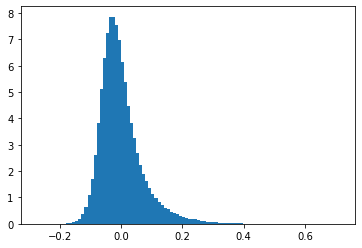

In [7]:
from matplotlib import pyplot as plt
_, _, _ = plt.hist(fp32_fc.weight.detach().flatten(), density=True, bins=100)
plt.show()

### Attempt 2: Scale before Round

This time, we rescale the parameters into an appropriate output range before rounding. 

What's a good output range? It depends on the quantization precision you want

#### Choosing the quantized ouput range

In [8]:
def get_output_range(bits):
    alpha_q = -2 ** (bits - 1)
    beta_q = 2 ** (bits - 1) - 1
    return alpha_q, beta_q


print("For 16-bit quantization, the quantized range is ", get_output_range(16))
print("For 8-bit quantization, the quantized range is ", get_output_range(8))
print("For 4-bit quantization, the quantized range is ", get_output_range(4))

For 16-bit quantization, the quantized range is  (-32768, 32767)
For 8-bit quantization, the quantized range is  (-128, 127)
For 4-bit quantization, the quantized range is  (-8, 7)


In this example, we're going to use 8-bit quantization. So the output range to scale our parameters is [-128, 127].

#### Moving from FP32 to INT8

<img src="img/scaling.png" width="600">

Generally speaking, what we're doing here is an affine transformation from 32-bit space to 8-bit space.

These are of the form `y  = Ax + B`

The two parameters for this transformation are: 
* The scaling factor `S`     
* The zero-point `Z`         

So our transformation looks like `Q(x) = round(x/S + Z)`

In [9]:
def get_quantization_params(input_range, output_range):
    min_val, max_val = input_range
    alpha_q, beta_q = output_range
    S = (max_val - min_val) / (beta_q - alpha_q)
    Z = alpha_q - (min_val / S)
    return S, Z


def scale_transform(x, S, Z):
    x_q = 1/S * x + Z  
    x_q = torch.round(x_q).to(torch.int8)
    return x_q


def quantize_int8(x):
    S, Z = get_quantization_params(input_range=(x.min(), x.max(),), output_range=(-128, 127))
    x_q = scale_transform(x, S, Z)
    return x_q, S, Z


def dequantize(x_q, S, Z):
    x = S * (x_q - Z)
    return x


Now we have all the functions we need to quantize our classifier.

Like before, we quantize each parameter in the layer (`weights` and `bias` in this case). 

We will also quantize the inputs to the layer.

#### Quantize classifier

In [10]:
def quantize_classifier(clf):
    W_q, S_w, Z_w = quantize_int8(clf.weight)
    b_q, S_b, Z_b = quantize_int8(clf.bias)
    return (W_q, S_w, Z_w, b_q, S_b, Z_b)

#### Quantize inputs

In [11]:
def quantize_inputs(img):
    features = resnet(img)
    X_q, S_x, Z_x = quantize_int8(features)
    return (X_q, S_x, Z_x)

#### Quantized Matrix Multiplication

In PyTorch, the quantized operators run in specialized backends like FBGEMM and QNNPACK.

We can simulate the INT8 matmul by first dequantizing everything to FP32 and then running the multiply.

In [12]:
def int8_matmul_sim(quantized_input, quantized_layer):
    X = dequantize(*quantized_input)
    W = dequantize(*quantized_layer[:3])
    b = dequantize(*quantized_layer[3:])
    return b + X @ W.T

#### Run Quantized and Non-Quantized forward pass

In [13]:
# Non-Quantized
model = torch.nn.Sequential(resnet, fp32_fc)
logits = model(img)

# Quantized
inputs_q = quantize_inputs(img)
classifier_q = quantize_classifier(fp32_fc)
logits_q = int8_matmul_sim(inputs_q, classifier_q)

#### Compare Q and N-Q logits

In [14]:
# Compare quantized and non-quantized logits
print("Non-Quantized output:\n", logits[:, :10], "\n")
print("Quantized output:\n", logits_q[:, :10], "\n")

quantization_error = (logits_q - logits).mean()
print("Quantization error = ", quantization_error)

Non-Quantized output:
 tensor([[ 0.2827, -1.5461,  1.2094, -0.2907, -3.6378,  0.8214, -1.3164, -3.7967,
         -1.8691, -1.7165]]) 

Quantized output:
 tensor([[ 0.2997, -1.5684,  1.2295, -0.2559, -3.6580,  0.8425, -1.3213, -3.8168,
         -1.8718, -1.7032]]) 

Quantization error =  tensor(-0.0010)


The quantization error is pretty sizable at 1e-3. 

Eyeballing the outputs, the logits from the quantized and non-quantized layers seem fairly different too.

Let's see by how much are the quantized predictions off...

In [15]:
# check their outputs for same input
print("Non-Quantized prediction:")
get_predictions(logits)
print()
print("Quantized prediction:")
get_predictions(logits_q)

Non-Quantized prediction:
timber wolf, grey wolf, gray wolf, Canis lupus ( 0.44803616404533386 )

Quantized prediction:
timber wolf, grey wolf, gray wolf, Canis lupus ( 0.445095956325531 )


Not by much! The quantized logits predict the same class, albeit with slightly lower confidence.

Let's try more images

In [16]:
# Similarly for an image of a swan
img_url = "img/swan-3299528_1280.jpeg"
# img_url = "https://static.scientificamerican.com/sciam/cache/file/32665E6F-8D90-4567-9769D59E11DB7F26_source.jpg"
# img_url = "https://media.newyorker.com/photos/5dfab39dde5fcf00086aec77/1:1/w_1706,h_1706,c_limit/Lane-Cats.jpg"

img = load_img(img_url)

# Non-Quantized
model = torch.nn.Sequential(resnet, fp32_fc)
logits = model(img)

# Quantized
inputs_q = quantize_inputs(img)
classifier_q = quantize_classifier(fp32_fc)
logits_q = int8_matmul_sim(inputs_q, classifier_q)


# Compare predictions
print("Non-Quantized prediction:")
get_predictions(logits)
print()
print("Quantized prediction:")
get_predictions(logits_q)



Non-Quantized prediction:
goose ( 0.5297383666038513 )

Quantized prediction:
goose ( 0.5486957430839539 )
